In [1]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import Normalizer, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
import scipy.cluster.hierarchy as shc
import matplotlib.patheffects as PathEffects

In [2]:
from resources import ConfigS3
define = ConfigS3()

In [3]:
import config as CONFIG
import boto3
client_s3 = boto3.client('s3',
                    region_name=CONFIG.S3_REGION,
                    aws_access_key_id=CONFIG.S3_ACCESS_KEY,
                    aws_secret_access_key=CONFIG.S3_SECRET_ACCESS_KEY
                    )

In [4]:
folder_path = 'Result_with_velocity'
csv_list_file = define.bucket.objects.filter(Prefix=folder_path)

In [5]:
total_df = pd.DataFrame()
count = 0
for obj in csv_list_file:
    try:
        define.download_file_from_s3(obj.key, obj.key)
        temp_df = pd.read_csv(obj.key)
        total_df = pd.concat([total_df, temp_df])
    except:
        pass
    define.remove_local_file(obj.key)

Result_with_velocity/2023-04-19.csv
Result_with_velocity/2023-04-20.csv
Result_with_velocity/2023-04-21.csv
Result_with_velocity/2023-04-22.csv
Result_with_velocity/2023-04-23.csv
Result_with_velocity/2023-04-24.csv
Result_with_velocity/2023-04-25.csv
Result_with_velocity/2023-04-26.csv
Result_with_velocity/2023-04-27.csv
Result_with_velocity/2023-04-28.csv
Result_with_velocity/2023-04-29.csv
Result_with_velocity/2023-04-30.csv
Result_with_velocity/2023-05-01.csv
Result_with_velocity/2023-05-02.csv
Result_with_velocity/2023-05-03.csv
Result_with_velocity/2023-05-04.csv
Result_with_velocity/2023-05-05.csv
Result_with_velocity/2023-05-06.csv
Result_with_velocity/2023-05-07.csv
Result_with_velocity/2023-05-08.csv
Result_with_velocity/2023-05-09.csv
Result_with_velocity/2023-05-10.csv
Result_with_velocity/2023-05-11.csv


In [6]:
total_df.head(5)

,Unnamed: 0,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,is_morning,duration
0,0,period_19_50,23795,2023-04-19,2,28,C,True,few clouds,27,quan_go_vap,0,1
1,1,period_19_50,60703,2023-04-19,2,28,C,True,few clouds,27,quan_go_vap,0,1
2,2,period_19_50,23794,2023-04-19,2,28,C,True,few clouds,27,quan_go_vap,0,1
3,3,period_19_50,60704,2023-04-19,2,28,C,True,few clouds,27,quan_go_vap,0,1
4,4,period_19_50,60538,2023-04-19,2,28,C,True,few clouds,27,quan_go_vap,0,1


In [8]:
total_df.drop(["Unnamed: 0"], axis=1, inplace=True)
total_df.head(5)

,period,segment_id,date,weekday,tomtom_velocity,base_LOS,isHot,weather,temperature,district,is_morning,duration
0,period_19_50,23795,2023-04-19,2,28,C,True,few clouds,27,quan_go_vap,0,1
1,period_19_50,60703,2023-04-19,2,28,C,True,few clouds,27,quan_go_vap,0,1
2,period_19_50,23794,2023-04-19,2,28,C,True,few clouds,27,quan_go_vap,0,1
3,period_19_50,60704,2023-04-19,2,28,C,True,few clouds,27,quan_go_vap,0,1
4,period_19_50,60538,2023-04-19,2,28,C,True,few clouds,27,quan_go_vap,0,1


In [9]:
label_encoder = LabelEncoder()
# total_df['base_LOS']= label_encoder.fit_transform(total_df['base_LOS'])
total_df['isHot']= label_encoder.fit_transform(total_df['isHot'])
total_df['weather']= label_encoder.fit_transform(total_df['weather'])

In [10]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145898 entries, 0 to 49913
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   period           1145898 non-null  object
 1   segment_id       1145898 non-null  int64 
 2   date             1145898 non-null  object
 3   weekday          1145898 non-null  int64 
 4   tomtom_velocity  1145898 non-null  int64 
 5   base_LOS         1145898 non-null  object
 6   isHot            1145898 non-null  int64 
 7   weather          1145898 non-null  int64 
 8   temperature      1145898 non-null  int64 
 9   district         1145898 non-null  object
 10  is_morning       1145898 non-null  int64 
 11  duration         1145898 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 113.7+ MB


In [11]:
def _elbow_function(period_df):
    period_df_time = period_df.drop(["period", "weekday", "temperature", "segment_id", "isHot", "weather", "base_LOS", "district", "is_morning", "date"], axis=1)
    scaled_df = StandardScaler().fit_transform(period_df_time)
    sse = []
    # Lặp qua các giá trị k từ 1 đến 10
    for k in range(1, 11):
        # Khởi tạo model KMeans với số lượng cụm k
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        # Fit dữ liệu vào model
        kmeans.fit(scaled_df)
        # Lưu giá trị SSE vào mảng
        sse.append(kmeans.inertia_)
    
    # Vẽ biểu đồ Elbow để tìm số lượng cụm tối ưu
    plt.plot(range(1, 11), sse)
    plt.title('Phương pháp Elbow')
    plt.xlabel('Số lượng cụm')
    plt.ylabel('SSE')
    plt.show()
    
    return sse

In [13]:
def find_optimal_k(X, is_test = False):
    # Initialize variables
    Ks = range(2, 11)
    scores_elbow = []
    scores_silhouette = []

    # Loop over different values of K
    for K in Ks:
        # Fit K-means model
        kmeans = KMeans(n_clusters=K, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)

        # Calculate distortion (elbow criterion)
        distortion = kmeans.inertia_
        scores_elbow.append(distortion)

        # Calculate Silhouette Score
        if K > 1:
            silhouette_avg = silhouette_score(X, kmeans.labels_)
            scores_silhouette.append(silhouette_avg)
        else:
            scores_silhouette.append(0)

    # Find optimal K based on elbow criterion and Silhouette Score
    scores_elbow = np.array(scores_elbow)
    scores_silhouette = np.array(scores_silhouette)
    diff = np.diff(scores_elbow)
    elbow_index = np.argmax(diff)
    silhouette_index = np.argmax(scores_silhouette)
    print("elbow_index", elbow_index)
    print("silhouette_index", silhouette_index)
    
    scores_elbow_silhouette = diff/scores_silhouette[:-1]
    
    n_numbers = range(2, 11)
    optimal_K = n_numbers[np.argmax(scores_elbow_silhouette)]
    
#     K = silhouette_index if abs(elbow_index - silhouette_index) <= 2 or elbow_index_2 == silhouette_index else elbow_index_1
    if abs(elbow_index - silhouette_index) <=2:
        K = elbow_index  if elbow_index > silhouette_index else silhouette_index
    else:
        K = elbow_index 
    print("--------", K)
    print("optimal K", optimal_K)
    if is_test:
        # Plot results
        plt.plot(Ks, scores_elbow, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method showing the optimal k')
        plt.axvline(x=optimal_K, linestyle='--', color='red', label='Optimal k (elbow)')
        plt.legend()
        plt.show()

        plt.plot(Ks, scores_silhouette, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Silhouette Score')
        plt.title('The Silhouette Score showing the optimal k')
        plt.axvline(x=optimal_K, linestyle='--', color='red', label='Optimal k (Silhouette Score)')
        plt.legend()
        plt.show()
    return optimal_K


In [14]:
def k_mean_function(scaled_df, k_number = 4):
    kmeans = KMeans(n_clusters=k_number, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_df)
    
    return kmeans.labels_


In [32]:
def _plot_kmean_scatter(X, labels):
    '''
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    '''
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    print("num_classes", num_classes)
    palette = np.array(sns.color_palette("hls", num_classes))
    print("palette", len(palette))
    print("labels", len(labels))

    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(12, 10))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int32)])

    # thêm nhãn cho mỗi cluster
    txts = []

    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title('t-sne visualization')
    image_path = "ImageResults/kmean.jpg"
    plt.savefig("ImageResults/kmean.jpg")
    define.upload_file_to_s3(image_path,image_path)
    return image_path


In [16]:
def _plot_dendograms(scaled_df):
    plt.figure(figsize=(20, 7))
    plt.title("Dendograms")
    dend = shc.dendrogram(shc.linkage(scaled_df, method='ward'))
    plt.axhline(200, linestyle='--')
    plt.xlabel('sample indice')
    plt.ylabel('dissimilarity metric cluster')

In [17]:
def AgglomerativeClustering_function(scaled_df, number_clusters = 4):
    cluster = AgglomerativeClustering(n_clusters=number_clusters, affinity='euclidean', linkage='ward')
    labels = cluster.fit_predict(scaled_df)
    return labels

In [18]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np

def DBSAN_function(X):
    std = MinMaxScaler()
    X_std = std.fit_transform(X)

    # Define range of values for epsilon and minPts
    eps_range = np.arange(0.1, 1.0, 0.1)
    minPts_range = range(1, 11)

    # Define parameters for Grid Search
    param_grid = {'eps': eps_range, 'min_samples': minPts_range}

    # Define DBSCAN model
    dbscan = DBSCAN()
    # Define custom scorer
    silhouette_scorer = make_scorer(silhouette_score)

    # Define Grid Search object
    grid_search = GridSearchCV(dbscan, param_grid=param_grid, scoring=silhouette_scorer)

    # Fit Grid Search object to data
    grid_search.fit(X_std)

    # Print best parameters and best score
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Silhouette Score: ", grid_search.best_score_)
    return grid_search.best_params_


In [19]:
def test_dbscan(X):
    std = MinMaxScaler()
    X_std = std.fit_transform(X)
    dbscan = DBSCAN(eps=0.1, min_samples=11, metric='euclidean')
    labels = dbscan.fit_predict(X_std)
    return labels


In [20]:
from sklearn.manifold import TSNE

In [21]:
def get_label_with_Agglomerative(period_df,  number_clusters = 4, is_test = False):
    period_df_time = period_df.drop(["period", "weekday", "temperature", "segment_id", "isHot", "weather", "base_LOS", "district", "is_morning", "date"], axis=1, errors = 'raise')
    if "label" in period_df_time.columns:
        period_df_time = period_df_time.drop(["label"], axis = 1)
    scaled_df = MinMaxScaler().fit_transform(period_df_time)
    _plot_dendograms(scaled_df)
    label_result = AgglomerativeClustering_function(scaled_df, number_clusters)
    if is_test:
        X_tsne = TSNE(n_components=2, random_state=123).fit_transform(scaled_df)
        _plot_kmean_scatter(scaled_df, label_result)
    return label_result


In [48]:
def get_label(period_df, is_test = False):
    period_df_time = period_df.drop(["period", "weekday", "temperature", "segment_id", "isHot", "weather", "base_LOS", "district", "is_morning", "date"], axis=1)
    if "label" in period_df_time.columns:
        period_df_time = period_df_time.drop(["label"], axis = 1)
    scaled_df = MinMaxScaler().fit_transform(period_df_time)
    print(scaled_df.shape)
    k_number = find_optimal_k(scaled_df, is_test)
    label_result = k_mean_function(scaled_df, k_number)
    if is_test:
#         X_tsne = TSNE(n_components=2, random_state=123).fit_transform(scaled_df)
        _plot_kmean_scatter(period_df_time.values, label_result)
    return label_result

In [23]:
def get_label_with_DBSAN(period_df, is_test = False):
    period_df_time = period_df.drop(["period", "weekday", "temperature", "segment_id", "isHot", "weather", "base_LOS", "district", "is_morning", "date"], axis=1)
    if "label" in period_df_time.columns:
        period_df_time = period_df_time.drop(["label"], axis = 1)
    scaled_df = MinMaxScaler().fit_transform(period_df_time)
    a = DBSAN_function(period_df_time)
    label_result = test_dbscan(scaled_df)
    if is_test:
        _plot_kmean_scatter(scaled_df, label_result)
    return label_result

In [24]:
for i in total_df.district.unique():
    print("----", i)
    temp_df = total_df.loc[(total_df.district == i)]
    print(len(temp_df))

---- quan_go_vap
58266
---- huyen_binh_chanh
151060
---- quan_2
47476
---- quan_binh_tan
71214
---- quan_12
133796
---- quan_tan_phu
53950
---- quan_5
69056
---- quan_tan_binh
176956
---- quan_7
60424
---- quan_9
12948
---- quan_thu_duc
110058
---- quan_6
30212
---- quan_1
62582
---- quan_4
6474
---- quan_10
25896
---- huyen_hoc_mon
75530


In [51]:
print(sorted(total_df.period.unique()))

['period_06_25', 'period_06_30', 'period_06_35', 'period_06_40', 'period_06_45', 'period_06_50', 'period_06_55', 'period_07_00', 'period_07_05', 'period_07_10', 'period_07_15', 'period_07_20', 'period_07_25', 'period_07_30', 'period_07_35', 'period_07_40', 'period_07_45', 'period_07_50', 'period_07_55', 'period_08_00', 'period_08_05', 'period_08_10', 'period_08_15', 'period_08_20', 'period_08_25', 'period_08_30', 'period_08_35', 'period_08_40', 'period_08_45', 'period_08_50', 'period_08_55', 'period_09_00', 'period_09_05', 'period_09_10', 'period_09_15', 'period_09_20', 'period_09_25', 'period_09_30', 'period_09_35', 'period_09_40', 'period_09_45', 'period_09_50', 'period_09_55', 'period_10_00', 'period_10_05', 'period_10_10', 'period_10_15', 'period_10_20', 'period_10_25', 'period_10_30', 'period_15_55', 'period_16_00', 'period_16_05', 'period_16_10', 'period_16_15', 'period_16_20', 'period_16_25', 'period_16_30', 'period_16_35', 'period_16_40', 'period_16_45', 'period_16_50', 'period

In [41]:
parammeters = {
    "period": ["period_16_55"],
    "weekday": [1],
    "district": ["quan_binh_tan", "quan_10", "quan_tan_phu"],
#     "is_morning": [1]
}

period_df = total_df.copy()
for key, value in parammeters.items():
    period_df = period_df.loc[period_df[key].isin(value)]
    
print(period_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 18627 to 19050
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   period           210 non-null    object
 1   segment_id       210 non-null    int64 
 2   date             210 non-null    object
 3   weekday          210 non-null    int64 
 4   tomtom_velocity  210 non-null    int64 
 5   base_LOS         210 non-null    object
 6   isHot            210 non-null    int64 
 7   weather          210 non-null    int64 
 8   temperature      210 non-null    int64 
 9   district         210 non-null    object
 10  is_morning       210 non-null    int64 
 11  duration         210 non-null    int64 
dtypes: int64(8), object(4)
memory usage: 21.3+ KB
None


(210, 2)
elbow_index 7
silhouette_index 0
-------- 7
optimal K 9


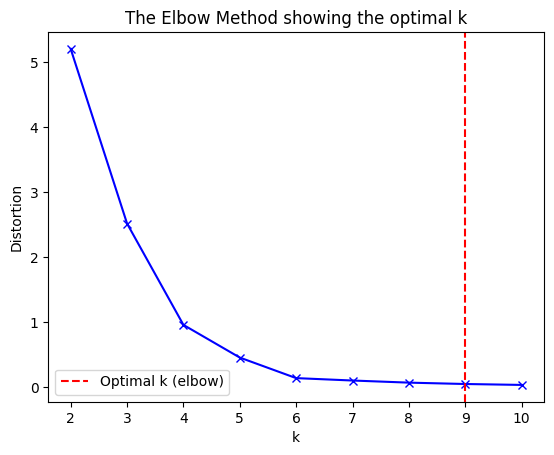

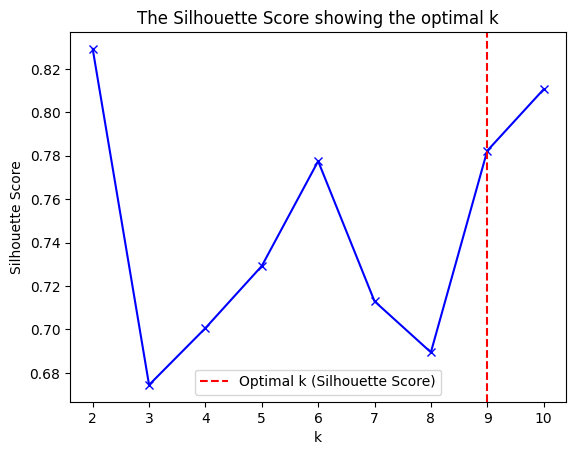

num_classes 9
palette 9
labels 210


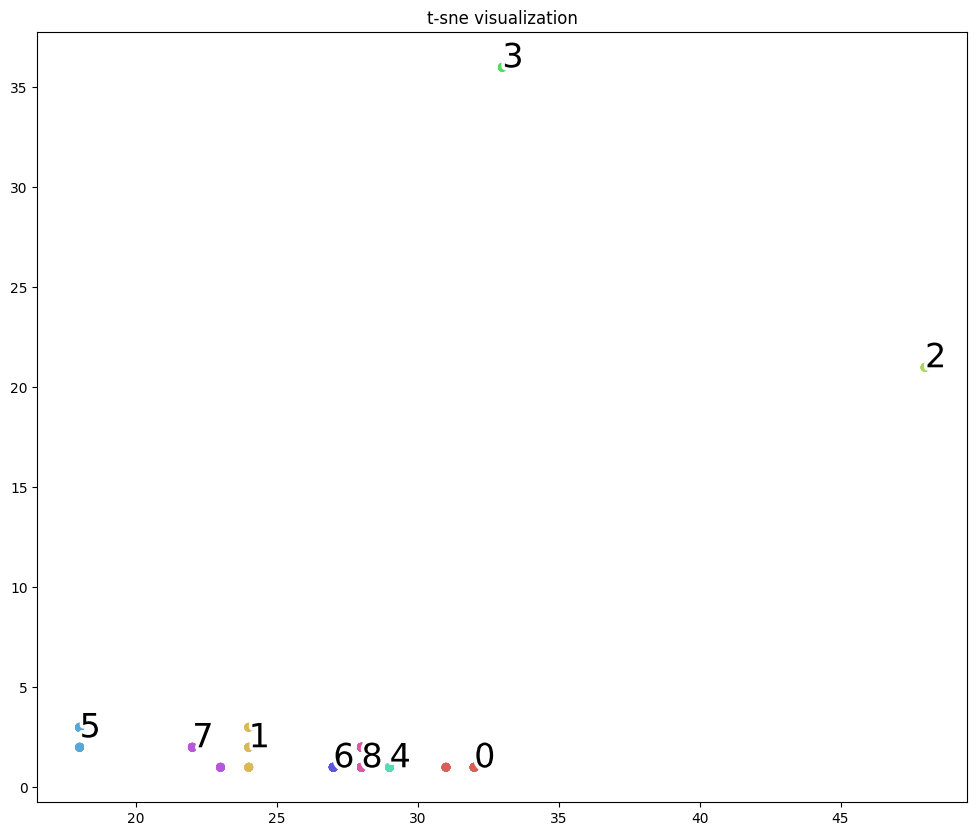

In [52]:
kmeans_labels = get_label(period_df, is_test=True)
period_df["label"] = kmeans_labels

In [75]:
group_result = period_df.groupby(["label"]).agg({"segment_id":["unique","count"], "tomtom_velocity":["max","min"], "duration":["max","min"]})
print(group_result.tomtom_velocity["max"][0])

32


In [77]:
result = []
group_result = period_df.groupby(["label"]).agg({"segment_id":["unique","count"], "tomtom_velocity":["max","min"], "duration":["max","min"]})
for item_label in period_df['label'].unique():
    temp_item={
        "label": item_label,
        "seg_id_list": group_result.segment_id.unique[item_label],
        "velocity":{
            "max": group_result.tomtom_velocity["max"][item_label],
            "min": group_result.tomtom_velocity["min"][item_label]
        },
        "duration":{
            "max": group_result.duration["max"][item_label],
            "min": group_result.duration["min"][item_label]
        }    
    }
    print(temp_item)

{'label': 0, 'seg_id_list': array([52050, 52049, 49701, 49702, 81598, 81597, 81587, 81588, 52051,
       35227, 35229, 19596, 19595, 35226, 35228, 42743, 42742, 42744]), 'velocity': {'max': 32, 'min': 31}, 'duration': {'max': 1, 'min': 1}}
{'label': 1, 'seg_id_list': array([19576, 30917, 72758, 19574, 19577, 42822, 72757, 30918, 19575,
       42821, 72857, 44481, 72858, 44516, 44482, 44515]), 'velocity': {'max': 24, 'min': 24}, 'duration': {'max': 3, 'min': 1}}
{'label': 8, 'seg_id_list': array([72857, 44481, 72858, 44516, 44482, 44515, 42955, 42957,  8723,
        8722,  8721,  8720, 42956, 42958, 60431, 60429, 71374, 71373,
        8725, 42881,  8724, 42953, 60432, 60430, 42954, 42883, 42882,
       71371, 42884, 71372, 19576, 30917, 72758, 19574, 19577, 42822,
       72757, 30918, 19575, 42821, 35227, 35229, 19596, 19595, 35226,
       35228, 42743, 42742, 42744]), 'velocity': {'max': 28, 'min': 28}, 'duration': {'max': 2, 'min': 1}}
{'label': 7, 'seg_id_list': array([35227, 35229, 

In [79]:
import numpy as np
import json

arr = np.array([1, 2, 3], dtype=np.int64)
arr = arr.tolist()  # Chuyển đổi mảng thành kiểu dữ liệu có thể mã hóa JSON
a = {"a": arr}
json_data = json.dumps(a)  # Mã hóa thành JSON

print(json_data)


{"a": [1, 2, 3]}


/Users/xaviele/Documents/MASTER/THEORY/Example_UrbanTrafficCondition_Sharding/env/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


num_classes 9
palette 9
labels 210


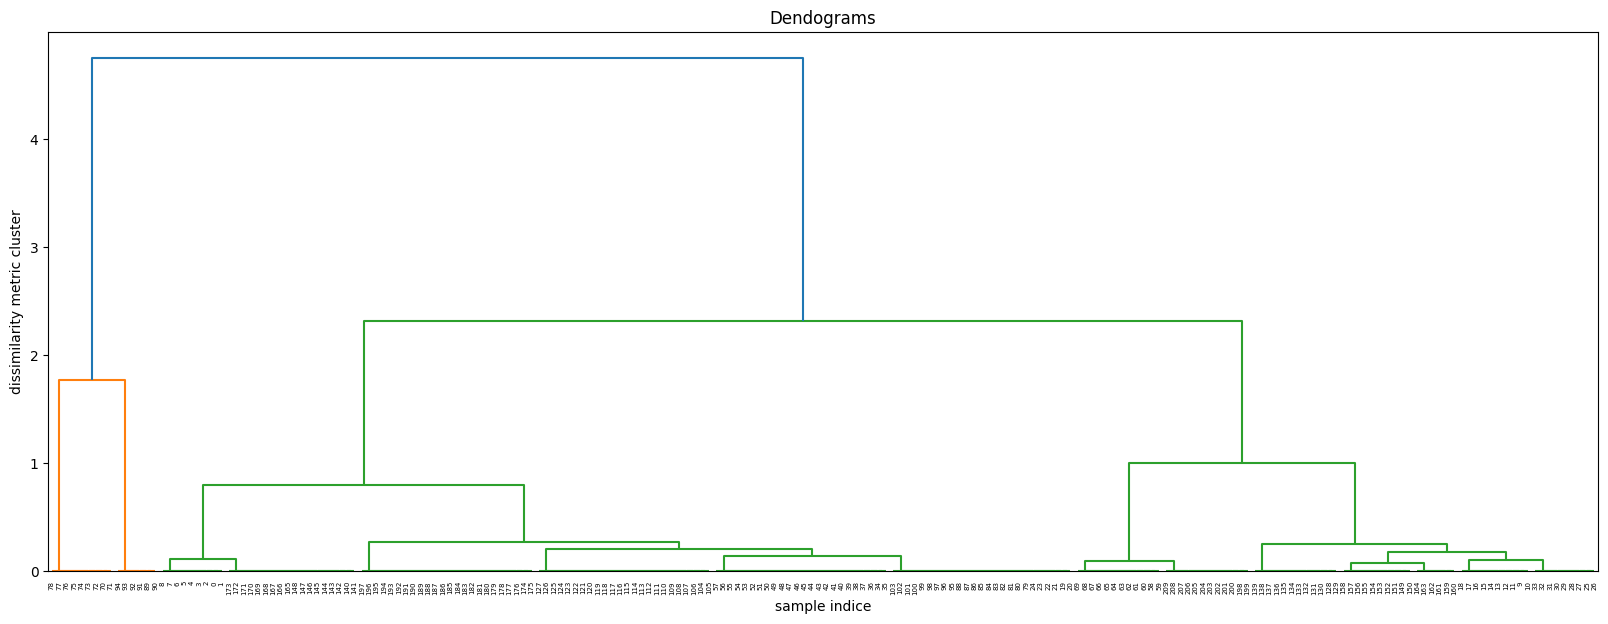

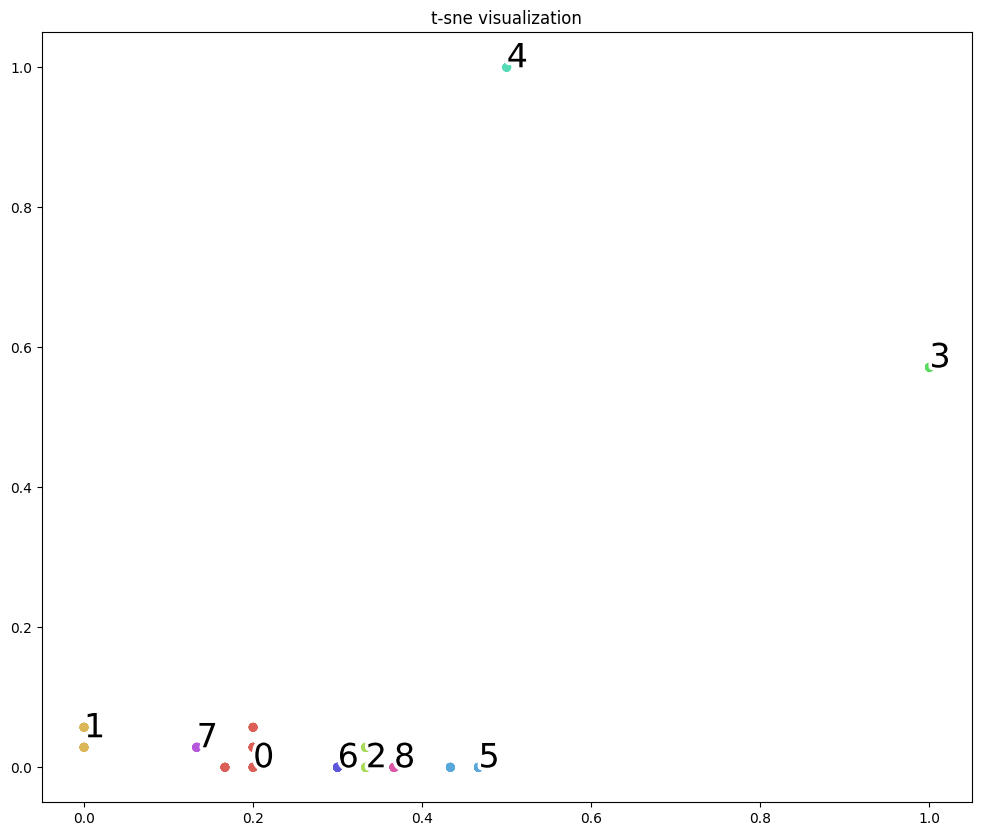

In [30]:
hierarchical_labels = get_label_with_Agglomerative(period_df, 9, is_test=True)
# period_df_2["label"] = label_result_test

In [31]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import fowlkes_mallows_score

# assume kmeans_labels and hierarchical_labels are the cluster labels obtained from k-means and hierarchical clustering, respectively
ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)
nmi = normalized_mutual_info_score(kmeans_labels, hierarchical_labels)
fmi = fowlkes_mallows_score(kmeans_labels, hierarchical_labels)

print("Adjusted Rand Index: ", ari)
print("Normalized Mutual Information: ", nmi)
print("Fowlkes-Mallows Index: ", fmi)


Adjusted Rand Index:  0.9340524645802162
Normalized Mutual Information:  0.960346944361584
Fowlkes-Mallows Index:  0.9432833620541063


In [25]:

for item_label in sorted(period_df_2["label"].unique()):
    print("----label----------:", item_label)
    test_df = period_df_2.loc[(period_df_2.label == item_label)]
    print("velocity", test_df.tomtom_velocity.unique())
    print("base_LOS", test_df.base_LOS.unique())
    print("duration", test_df.duration.unique())
    print("Len", len(test_df))

----label----------: 0
velocity [31 32]
base_LOS ['B']
duration [1]
Len 27
----label----------: 1
velocity [22 23]
base_LOS ['D']
duration [2 1]
Len 21
----label----------: 2
velocity [48]
base_LOS ['A']
duration [21]
Len 9
----label----------: 3
velocity [33]
base_LOS ['B']
duration [36]
Len 6
----label----------: 4
velocity [28]
base_LOS ['C']
duration [1 2]
Len 49
----label----------: 5
velocity [18]
base_LOS ['E']
duration [2 3]
Len 24
----label----------: 6
velocity [24]
base_LOS ['D']
duration [1 2 3]
Len 26
----label----------: 7
velocity [27]
base_LOS ['C']
duration [1]
Len 24
----label----------: 8
velocity [29]
base_LOS ['C']
duration [1]
Len 24


In [78]:
dataset = frequent_list
# Sử dụng Apriori
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
# print(df)
frequent_itemsets_apriori = apriori(df, min_support=0.6, use_colnames=True)
print(frequent_itemsets_apriori)

# Sử dụng FP-Growth
frequent_itemsets_fpgrowth = fpgrowth(df, min_support=0.45, use_colnames=True)
print(frequent_itemsets_fpgrowth)

Empty DataFrame
Columns: [support, itemsets]
Index: []
       support                                           itemsets
0     0.459596                                            (42436)
1     0.459596                                            (42435)
2     0.459596                                            (42427)
3     0.459596                                            (42426)
4     0.459596                                            (33190)
...        ...                                                ...
4090  0.459596  (31200, 33185, 33186, 33187, 33188, 42436, 331...
4091  0.459596  (31200, 33185, 33186, 33187, 33188, 42436, 331...
4092  0.459596  (31200, 31201, 33186, 33187, 33188, 42436, 331...
4093  0.459596  (31200, 33185, 33186, 33187, 33188, 33189, 331...
4094  0.459596  (31200, 33185, 33186, 33187, 33188, 42436, 331...

[4095 rows x 2 columns]


In [52]:
print(frequent_itemsets_fpgrowth.iloc[1019].itemsets)
print(frequent_itemsets_fpgrowth.iloc[1021].itemsets)
print(len(frequent_itemsets_fpgrowth))

frozenset({60704, 65248, 65249, 23793, 23794, 23795, 60538, 60539, 60703})
frozenset({60704, 60705, 65248, 23793, 23794, 23795, 60538, 60539, 60703})
1023


In [53]:
dataset2 = []
list_len = []
for index in range(len(frequent_itemsets_fpgrowth)):
    temp_item = list(frequent_itemsets_fpgrowth.iloc[index].itemsets)
    list_len.append(len(temp_item))
    if len(temp_item) > 1:
        dataset2.append(temp_item)
print(len(dataset2))

1013


In [54]:
print(np.unique(list_len))

[ 1  2  3  4  5  6  7  8  9 10]


In [173]:
result_df = seg_df_time.groupby(["label"]).agg({"segment_id":["unique","count"], "tomtom_velocity":["max","min"], "duration":["max","min"]})
result_df

segment_id        \
                                                  unique count   
label                                                            
0      [21516, 2862, 2863, 2864, 2865, 2866, 2867, 28...  3402   
1      [21516, 2862, 2863, 2864, 2865, 2866, 2867, 28...   778   
2      [21512, 40469, 40470, 40471, 40472, 15414, 154...   256   
3      [21504, 21505, 21506, 21507, 21508, 21509, 215...  2044   

      tomtom_velocity     duration      
                  max min      max min  
label                                   
0                  50  49       10   9  
1                  50  32        1   1  
2                  13   4       10   1  
3                  43  31       10   8